# Evaluate consistency of velocity and cell fate probability across scale

In [1]:
import numpy as np
import pandas as pd
import torch
import cellrank as cr
import scipy

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvi
from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## General settings

In [2]:
%matplotlib inline

In [3]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


## Constants

In [4]:
DATASET = "scale_murine"

In [5]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

In [6]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR).mkdir(parents=True, exist_ok=True)

In [7]:
TERMINAL_STATES = ["Mesenchyme", "Sensory_1", "Sensory_2"]

In [8]:
TERMINAL_STATES_ALL = [
    "Melanocytes",
    "enFib",
    "SC",
    "Mesenchyme",
    "Sensory_1",
    "Sensory_2",
    "ChC",
    "SatGlia",
    "Gut_glia",
    "Gut_neuron",
    "Symp",
    "BCC",
]

In [9]:
TERMINAL_STATES_ALL = (
    TERMINAL_STATES_ALL
    + [i + "_1" for i in TERMINAL_STATES_ALL]
    + [i + "_2" for i in TERMINAL_STATES_ALL]
    + [i + "_3" for i in TERMINAL_STATES_ALL]
)

## Classify sensory neurons into two

In [10]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / f"adata_run_stage_2_regvelo_all_regulons.h5ad")

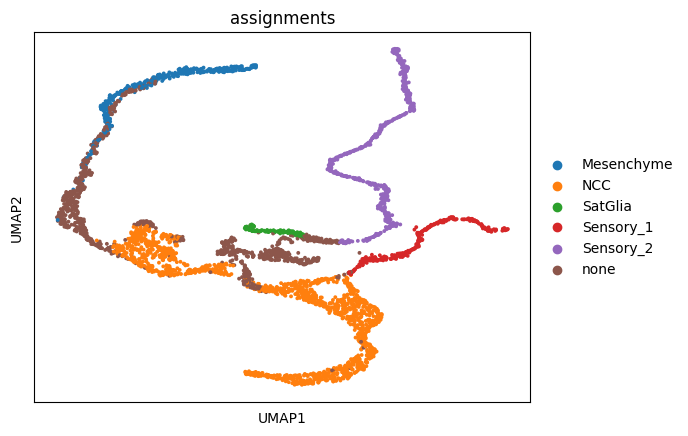

In [19]:
sc.pl.umap(adata, color="assignments")

In [12]:
sensory = adata[adata.obs["assignments"].isin(["Sensory"])].copy()

In [13]:
# sc.pp.neighbors(sensory)
sc.tl.leiden(sensory, resolution=0.1)
sc.tl.umap(sensory)

2025-06-05 10:25:27.134664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749111928.917989  544779 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749111929.581052  544779 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
sensory

AnnData object with n_obs × n_vars = 870 × 1122
    obs: 'plates', 'devtime', 'location', 'n_genes_by_counts', 'total_counts', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'leiden', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'TF', 'means', 'dispersions', 'dispersions_norm', 'velocity_genes', 'fit_beta', 'fit_gamma', 'fit_scaling'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'assignments_colors', 'devtime_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'location_colors', 'log1p', 'neighbors', 'network', 'paga', 'regulators', 'skeleton', 'targets

In [15]:
sensory.obs["assignments"] = sensory.obs["assignments"].astype(str)
# Assign "Sensory_1" where leiden == "1"
sensory.obs.loc[sensory.obs["leiden"] == "1", "assignments"] = "Sensory_1"
# Assign "Sensory_2" where leiden is "2" or "0"
sensory.obs.loc[sensory.obs["leiden"].isin(["2", "0"]), "assignments"] = "Sensory_2"

In [16]:
adata.obs["assignments"] = adata.obs["assignments"].astype(str)
adata.obs.loc[sensory.obs_names.tolist(), "assignments"] = sensory.obs["assignments"]

In [17]:
adata.obs.loc[sensory.obs_names.tolist(), "assignments"]

SS2_16_026:A13_unique.bam    Sensory_1
SS2_16_026:D20_unique.bam    Sensory_1
SS2_16_026:E9_unique.bam     Sensory_1
SS2_16_026:G3_unique.bam     Sensory_1
SS2_16_026:I24_unique.bam    Sensory_1
                               ...    
SS2_20_083:P19_unique.bam    Sensory_1
SS2_20_083:P17_unique.bam    Sensory_1
SS2_20_083:P20_unique.bam    Sensory_1
SS2_20_087:B16_unique.bam    Sensory_2
SS2_20_087:O2_unique.bam     Sensory_2
Name: assignments, Length: 870, dtype: object

In [18]:
adata

AnnData object with n_obs × n_vars = 3926 × 1122
    obs: 'plates', 'devtime', 'location', 'n_genes_by_counts', 'total_counts', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'leiden', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'TF', 'means', 'dispersions', 'dispersions_norm', 'velocity_genes', 'fit_beta', 'fit_gamma', 'fit_scaling'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'assignments_colors', 'devtime_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'location_colors', 'log1p', 'neighbors', 'network', 'paga', 'regulators', 'skeleton', 'target

## Measuring cell fate probabilities across different scale

In [20]:
fate_probs = []

for scale in [2, 3, 4, 5]:
    adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / f"adata_run_stage_{scale}_regvelo_all_regulons.h5ad")
    adata.obs["assignments"] = adata.obs["assignments"].astype(str)
    adata.obs.loc[sensory.obs_names.tolist(), "assignments"] = sensory.obs["assignments"]
    adata.obs["assignments"] = adata.obs["assignments"].astype("category")
    del adata.uns["assignments_colors"]

    vk = cr.kernels.VelocityKernel(adata)
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

    kernel = 0.8 * vk + 0.2 * ck
    # kernel = vk

    ## evaluate the fate prob on original space
    estimator = cr.estimators.GPCCA(kernel)

    n_states = 3
    for nround in range(100):
        estimator.compute_macrostates(n_states=n_states, cluster_key="assignments")
        if len(set(np.unique(estimator.macrostates.tolist())).intersection(TERMINAL_STATES)) == 3:
            estimator.set_terminal_states(
                list(set(np.unique(estimator.macrostates.tolist())).intersection(TERMINAL_STATES_ALL))
            )
            # estimator.plot_macrostates(which="terminal", discrete=True, legend_loc="on data", s=100)
            estimator.compute_fate_probabilities(solver="direct")
            print(str(n_states) + " works!")
            break
        n_states += 1

    fate_probs.append(
        pd.DataFrame(
            adata.obsm["lineages_fwd"], columns=adata.obsm["lineages_fwd"].names.tolist(), index=adata.obs_names
        )
    )

  0%|          | 0/3926 [00:00<?, ?cell/s]

  0%|          | 0/3926 [00:00<?, ?cell/s]

4 works!


  0%|          | 0/5139 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/5139 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

4 works!


  0%|          | 0/6273 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/6273 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


7 works!


  0%|          | 0/8821 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/8821 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


8 works!


In [21]:
fate_probs2 = []

for scale in [2, 3, 4, 5]:
    adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / f"adata_run_stage_{scale}_velovi_all_regulons.h5ad")
    adata.obs["assignments"] = adata.obs["assignments"].astype(str)
    adata.obs.loc[sensory.obs_names.tolist(), "assignments"] = sensory.obs["assignments"]
    adata.obs["assignments"] = adata.obs["assignments"].astype("category")
    del adata.uns["assignments_colors"]

    vk = cr.kernels.VelocityKernel(adata)
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

    kernel = 0.8 * vk + 0.2 * ck
    # kernel = vk

    ## evaluate the fate prob on original space
    estimator = cr.estimators.GPCCA(kernel)

    n_states = 3
    for nround in range(100):
        estimator.compute_macrostates(n_states=n_states, cluster_key="assignments")
        if len(set(np.unique(estimator.macrostates.tolist())).intersection(TERMINAL_STATES)) == 3:
            estimator.set_terminal_states(
                list(set(np.unique(estimator.macrostates.tolist())).intersection(TERMINAL_STATES_ALL))
            )
            # estimator.plot_macrostates(which="terminal", discrete=True, legend_loc="on data", s=100)
            estimator.compute_fate_probabilities(solver="direct")
            print(str(n_states) + " works!")
            break
        n_states += 1

    fate_probs2.append(
        pd.DataFrame(
            adata.obsm["lineages_fwd"], columns=adata.obsm["lineages_fwd"].names.tolist(), index=adata.obs_names
        )
    )

  0%|          | 0/3926 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/3926 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


3 works!


  0%|          | 0/5139 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/5139 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


4 works!


  0%|          | 0/6273 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/6273 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


5 works!


  0%|          | 0/8821 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/8821 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


13 works!


## Calculate consistency

In [22]:
cf_consis_rgv = []

for ct in ["Mesenchyme", "Sensory_1", "Sensory_2"]:
    scale_consis = pd.DataFrame(0, index=[1, 2, 3, 4], columns=[1, 2, 3, 4])
    for i in [1, 2, 3, 4]:
        for j in [1, 2, 3, 4]:
            cells = list(set(fate_probs[i - 1].index.tolist()).intersection(fate_probs[j - 1].index.tolist()))
            scale_consis.loc[i, j] = scipy.stats.spearmanr(
                fate_probs[i - 1].loc[cells, ct], fate_probs[j - 1].loc[cells, ct]
            )[0]

    rows, cols = np.triu_indices(scale_consis.shape[0], k=1)
    cf_consis_rgv += np.array(scale_consis)[rows, cols].tolist()
    print(
        "median:"
        + str(np.median(np.array(scale_consis)[rows, cols].tolist()))
        + ",min:"
        + str(np.min(np.array(scale_consis)[rows, cols].tolist()))
    )
    print("std:" + str(np.std(np.array(scale_consis)[rows, cols])))

median:0.9587626326031318,min:0.9237944519910019
std:0.017313863610011665
median:0.9423752445004702,min:0.9025188425306376
std:0.017753507783219654
median:0.7518128707168175,min:0.4461460712143073
std:0.1486721319556072


In [23]:
cf_consis_vi = []

for ct in ["Mesenchyme", "Sensory_1", "Sensory_2"]:
    scale_consis = pd.DataFrame(0, index=[1, 2, 3, 4], columns=[1, 2, 3, 4])
    for i in [1, 2, 3, 4]:
        for j in [1, 2, 3, 4]:
            cells = list(set(fate_probs2[i - 1].index.tolist()).intersection(fate_probs2[j - 1].index.tolist()))
            scale_consis.loc[i, j] = scipy.stats.spearmanr(
                fate_probs2[i - 1].loc[cells, ct], fate_probs2[j - 1].loc[cells, ct]
            )[0]

    rows, cols = np.triu_indices(scale_consis.shape[0], k=1)
    cf_consis_vi += np.array(scale_consis)[rows, cols].tolist()
    print(
        "median:"
        + str(np.median(np.array(scale_consis)[rows, cols].tolist()))
        + ",min:"
        + str(np.min(np.array(scale_consis)[rows, cols].tolist()))
    )
    print("std:" + str(np.std(np.array(scale_consis)[rows, cols])))

median:0.9322850238724748,min:0.8752014445041821
std:0.02891772631009028
median:0.7102842336404476,min:0.4394749104303848
std:0.18157652487012077
median:0.5431073780128315,min:0.21151749377227083
std:0.20012365528402898


In [24]:
import scipy

In [25]:
scipy.stats.ttest_ind(
    cf_consis_rgv,
    cf_consis_vi,
    equal_var=False,
    alternative="greater",
)

Ttest_indResult(statistic=2.6773361099672224, pvalue=0.006186431179324948)

In [26]:
np.mean(cf_consis_rgv)

0.8732589490297931

In [27]:
np.std(cf_consis_rgv)

0.13747980004181917

In [28]:
np.mean(cf_consis_vi)

0.6969089385825229

In [29]:
np.std(cf_consis_vi)

0.2342109163876494

In [234]:
dfs = []

g_df = pd.DataFrame({"Cell fate probabilities consistency": cf_consis_rgv})
g_df["Method"] = "RegVelo"
dfs.append(g_df)

g_df = pd.DataFrame({"Cell fate probabilities consistency": cf_consis_vi})
g_df["Method"] = "veloVI"
dfs.append(g_df)

df = pd.concat(dfs, axis=0)
df["Method"] = df["Method"].astype("category")

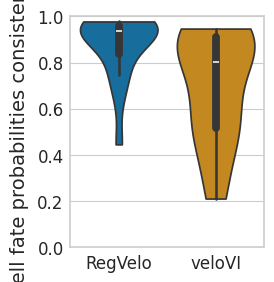

In [254]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(2.5, 3))
    pal = {"RegVelo": "#0173b2", "veloVI": "#de8f05"}

    sns.violinplot(
        data=df,
        ax=ax,
        # orient="h",
        x="Method",
        y="Cell fate probabilities consistency",
        order=["RegVelo", "veloVI"],
        cut=0,
        palette=pal,
    )
    # plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)
    # ax.set_yticks([0.7, 0.8, 0.9,1.0])
    # ax.set_yticklabels([0.7, 0.8, 0.9,1.0])
    plt.xlabel("")
    ax.set_ylim(0, 1)

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "consist_robustness.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()

## Plot heatmap

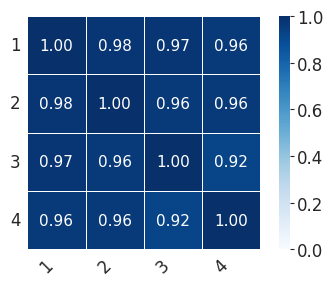

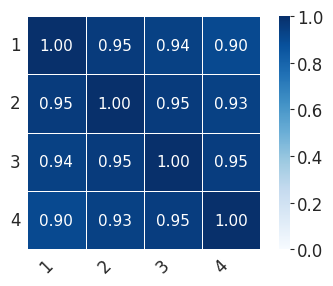

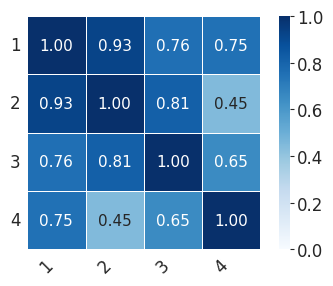

In [237]:
for ct in ["Mesenchyme", "Sensory_1", "Sensory_2"]:
    scale_consis = pd.DataFrame(0, index=[1, 2, 3, 4], columns=[1, 2, 3, 4])
    for i in [1, 2, 3, 4]:
        for j in [1, 2, 3, 4]:
            cells = list(set(fate_probs[i - 1].index.tolist()).intersection(fate_probs[j - 1].index.tolist()))
            scale_consis.loc[i, j] = scipy.stats.spearmanr(
                fate_probs[i - 1].loc[cells, ct], fate_probs[j - 1].loc[cells, ct]
            )[0]

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(4, 3))

        sns.heatmap(
            scale_consis,
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            square=True,
            cbar=True,
            cmap="Blues",
            vmin=0,
            vmax=1,
            ax=ax,
        )

        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)

        plt.tight_layout()

        if SAVE_FIGURES:
            plt.savefig(FIG_DIR / f"heatmap_{ct}_final.svg", format="svg", transparent=True, bbox_inches="tight")
        plt.show()